# Data
   In this competition we are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID.

Note: Not all transactions have corresponding identity information.


   ###   Transaction Table
   
   * The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

   * TransactionAMT: transaction payment amount in USD
  
   * ProductCD = product code, the product for each transaction

   * card1 - card6 = payment card information, such as card type, card category, issue bank, country, etc.

   * addr1, addr2 = address

   * P_emaildomain = purchaser and recipient email domain

   * R_emaildomain = purchaser and recipient email domain
   
   * dist: distance
    
   * C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
   
   * D1-D15: timedelta, such as days between previous transaction, etc.

   * Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

   * M1 - M9 = match, such as names on card and address, etc.


   ###   Identity Table

   * DeviceType 
 
   * DeviceInfo 

   * id_12 - id_38 = identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
   

   ###   Files

   * train_{transaction, identity}.csv - the training set

   * test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)

   * sample_submission.csv - a sample submission file in the correct format

# Libraries and Loading Data

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb

# to display all columns and rows:

pd.set_option('display.max_columns', None); 

In [261]:
%%time
train_transaction = pd.read_csv("data/train_transaction.csv")
train_identity =pd.read_csv("data/train_identity.csv")

test_transaction = pd.read_csv("data/test_transaction.csv")
test_identity =pd.read_csv("data/test_identity.csv")

CPU times: user 45.5 s, sys: 12.7 s, total: 58.2 s
Wall time: 1min 10s


In [262]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))

print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [263]:
# Merging transaction and identity dataset

df_train = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_test = test_transaction.merge(test_identity, on='TransactionID', how='left')

In [264]:
del train_identity, train_transaction, test_identity, test_transaction
print("Data set merged ")

Data set merged 


In [265]:
#A random 15% sample of the DataFrame with replacement:

train=df_train.sample(frac=0.15, replace=True, random_state=1)
test=df_test.sample(frac=0.15, replace=True, random_state=1)

In [266]:
def getCatFeatureDetail(df,cat_cols):
    cat_detail_dict = {} 
    for col in cat_cols:
        cat_detail_dict[col] = df[col].nunique()
    cat_detail_df = pd.DataFrame.from_dict(cat_detail_dict, orient='index', columns=['nunique'])
    print('There are ' + str(len(cat_cols)) + ' categorical columns.')
    print(cat_detail_df)

In [267]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
128037,3115037,0,2556337,59.00,W,7919,194.0,150.0,mastercard,202.0,debit,272.0,87.0,119.0,NaN,NaN,NaN,4.0,4.0,0.0,0.0,1.0,4.0,0.0,0.0,11.0,0.0,2.0,0.0,24.0,4.0,207.0,87.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,207.0,87.0,NaN,NaN,NaN,262.0,T,F,F,M0,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,445.000000,0.0,0.0,0.000000,0.0,0.0,445.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1780.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1780.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491755,3478755,0,12841509,117.00,W,13833,111.0,150.0,visa,226.0,debit,325

In [268]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
128037,3791586,22802142,279.950,W,15066,170.0,150.0,mastercard,102.0,credit,204.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,T,NaN,NaN,T,F,F,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491755,4155304,33827724,171.000,W,2884,490.0,150.0,visa,226.0,debit,420.0,87.0,1031.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,1.0,2.0,0.0,0

## Target Variable

In [270]:
train['isFraud'].value_counts()

0    85431
1     3150
Name: isFraud, dtype: int64

In [271]:
print('  {:.2f}% of Transactions that are fraud in train '.format(train['isFraud'].mean() * 100))

  3.56% of Transactions that are fraud in train 


Text(0.5, 1.0, 'isFraud variable count')

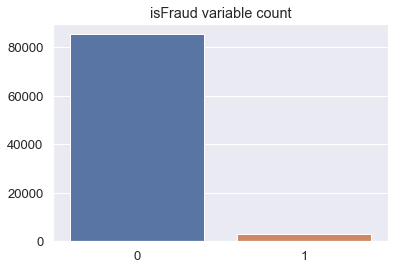

In [272]:
x=train['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('isFraud variable count')

* There is clearly a class imbalace problem. Imbalance means that the number of data points available for different the classes is different.
* We will look into methods of solving this issue later in this notebook.

## TransactionDT Variable

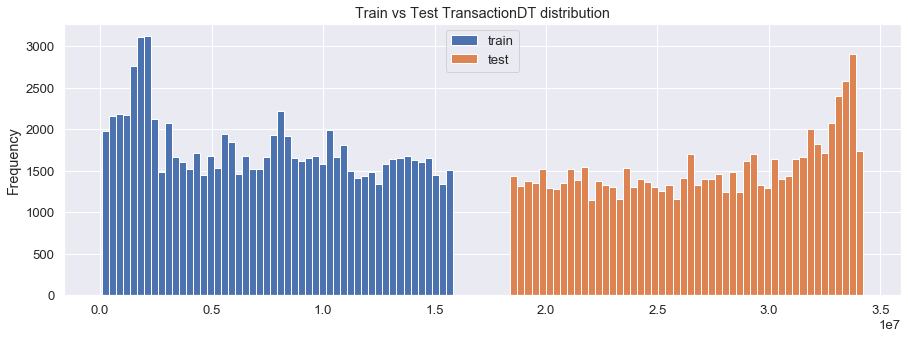

In [273]:
train['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

* The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp)
* It seems as if there is a time difference between testing and train operations.

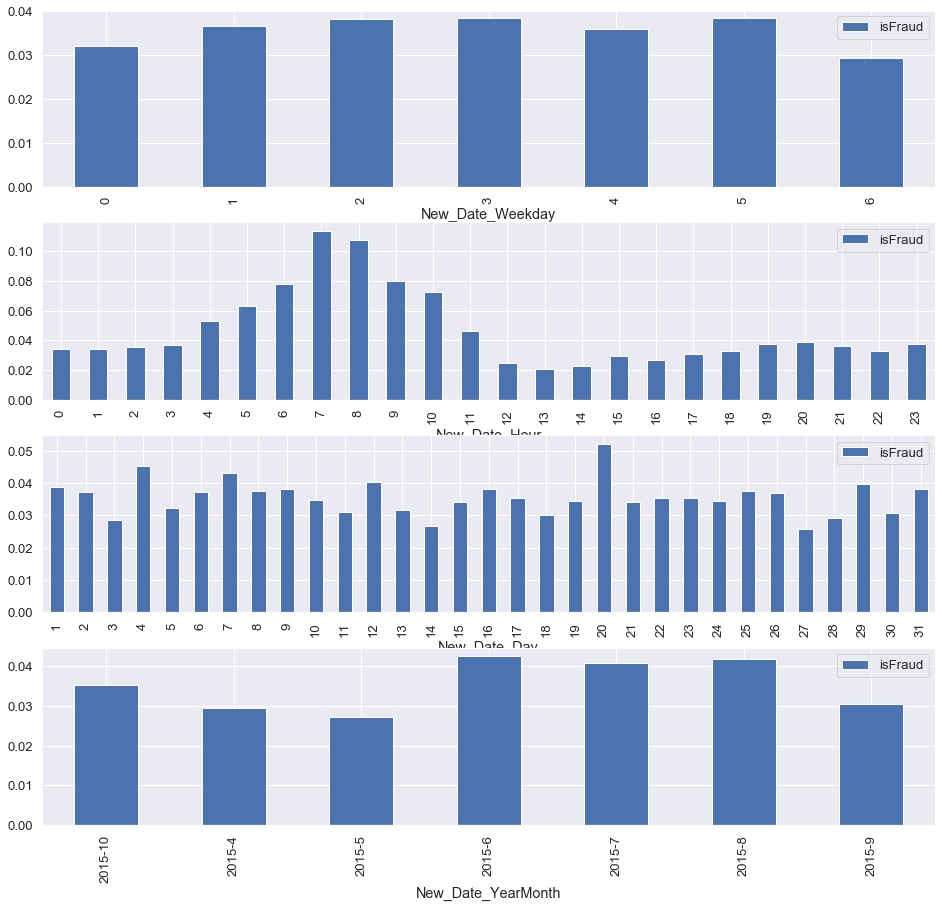

In [274]:
import datetime
START_DATE = '2015-04-22'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

train['New_Date'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train['New_Date_YMD'] = train['New_Date'].dt.year.astype(str) + '-' + train['New_Date'].dt.month.astype(str) + '-' + train['New_Date'].dt.day.astype(str)
train['New_Date_YearMonth'] = train['New_Date'].dt.year.astype(str) + '-' + train['New_Date'].dt.month.astype(str)
train['New_Date_Weekday'] = train['New_Date'].dt.dayofweek
train['New_Date_Hour'] = train['New_Date'].dt.hour
train['New_Date_Day'] = train['New_Date'].dt.day



test['New_Date'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
test['New_Date_YMD'] = test['New_Date'].dt.year.astype(str) + '-' + test['New_Date'].dt.month.astype(str) + '-' + test['New_Date'].dt.day.astype(str)
test['New_Date_YearMonth'] = test['New_Date'].dt.year.astype(str) + '-' + test['New_Date'].dt.month.astype(str)
test['New_Date_Weekday'] = test['New_Date'].dt.dayofweek
test['New_Date_Hour'] = test['New_Date'].dt.hour
test['New_Date_Day'] = test['New_Date'].dt.day



fig,ax = plt.subplots(4, 1, figsize=(16,15))

train.groupby('New_Date_Weekday')['isFraud'].mean().to_frame().plot.bar(ax=ax[0])
train.groupby('New_Date_Hour')['isFraud'].mean().to_frame().plot.bar(ax=ax[1])
train.groupby('New_Date_Day')['isFraud'].mean().to_frame().plot.bar(ax=ax[2])
train.groupby('New_Date_YearMonth')['isFraud'].mean().to_frame().plot.bar(ax=ax[3])

## TransactionAmt Variable

In [275]:
print(pd.concat([train[train['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 train[train['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01         7.5548     0.01          9.184
1  0.10        18.6020     0.10         25.981
2  0.25        35.4510     0.25         43.475
3  0.50        76.0230     0.50         67.950
4  0.75       161.0000     0.75        119.632
5  0.90       335.0000     0.90        261.950
6  0.99       994.0000     0.99       1104.000


In [276]:
print(' Fraud TransactionAmt mean      :  '+str(train[train['isFraud'] == 1]['TransactionAmt'].mean()))
print(' Non - Fraud TransactionAmt mean:  '+str(train[train['isFraud'] == 0]['TransactionAmt'].mean()))

 Fraud TransactionAmt mean      :  150.7164025396829
 Non - Fraud TransactionAmt mean:  133.11335310364902


* It looks like the mean of the fraud transaction amount is larger than the mean of non - fraud transaction amount.
*  I've taken a log transform in some of these plots to better show the distribution- otherwise the few, very large transactions skew the distribution. Because of the log transfrom, any values between 0 and 1 will appear to be negative.




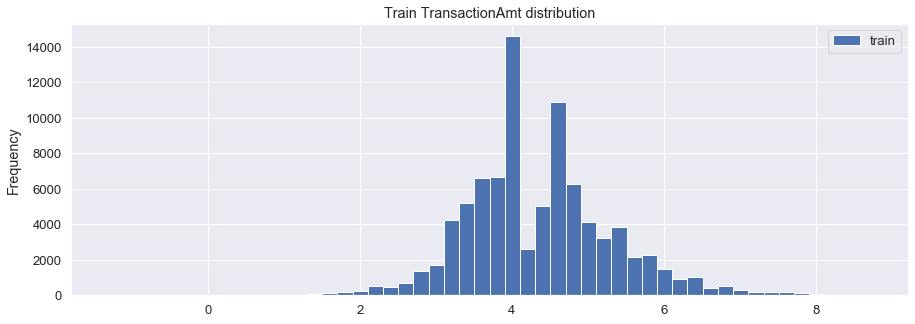

In [277]:
train['TransactionAmt'].apply(np.log).plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train TransactionAmt distribution')
plt.legend()
plt.show()

## ProductCD Variable (categorical)

* For now we don't know exactly what these values represent.
* W has the most number of observations, C the least.
* ProductCD C has the most fraud with >11%
* ProductCD W has the least with ~2%

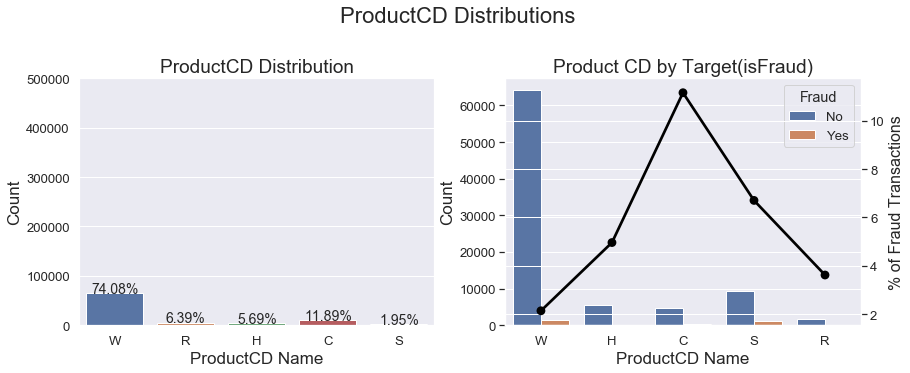

In [278]:
total = len (train)
tmp = pd.crosstab(train['ProductCD'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.show()

## Card 1-2-3-5 Variable

* Based on Competition Description, card features are categoricals.
* Lets understand the distribution of values
* What's the different in transactions and % of Fraud for each values in these features
* Card features has 6 columns, and 4 of them seems to be numericals

In [279]:
cols = [f'card{n}' for n in range(1,7)]
train[cols].isnull().sum()

card1       0
card2    1363
card3     222
card4     224
card5     622
card6     223
dtype: int64

In [280]:
train[cols].nunique()

card1    7126
card2     500
card3      77
card4       4
card5      79
card6       4
dtype: int64

* We can see that Card 1 and Card 2 has a large distribution of values, so maybe it will be better to get the log of these columns
* As the Card 1 and 2 are numericals, I will plot the distribution of them
in Card 3, as we have many values with low frequencies, I decided to set value to "Others"
Also, in Card 3 I set the % of Fraud ratio in yaxis2

In [281]:
train.loc[train.card3.isin(train.card3.value_counts()[train.card3.value_counts() < 200].index), 'card3'] = "Others"
train.loc[train.card5.isin(train.card5.value_counts()[train.card5.value_counts() < 300].index), 'card5'] = "Others"

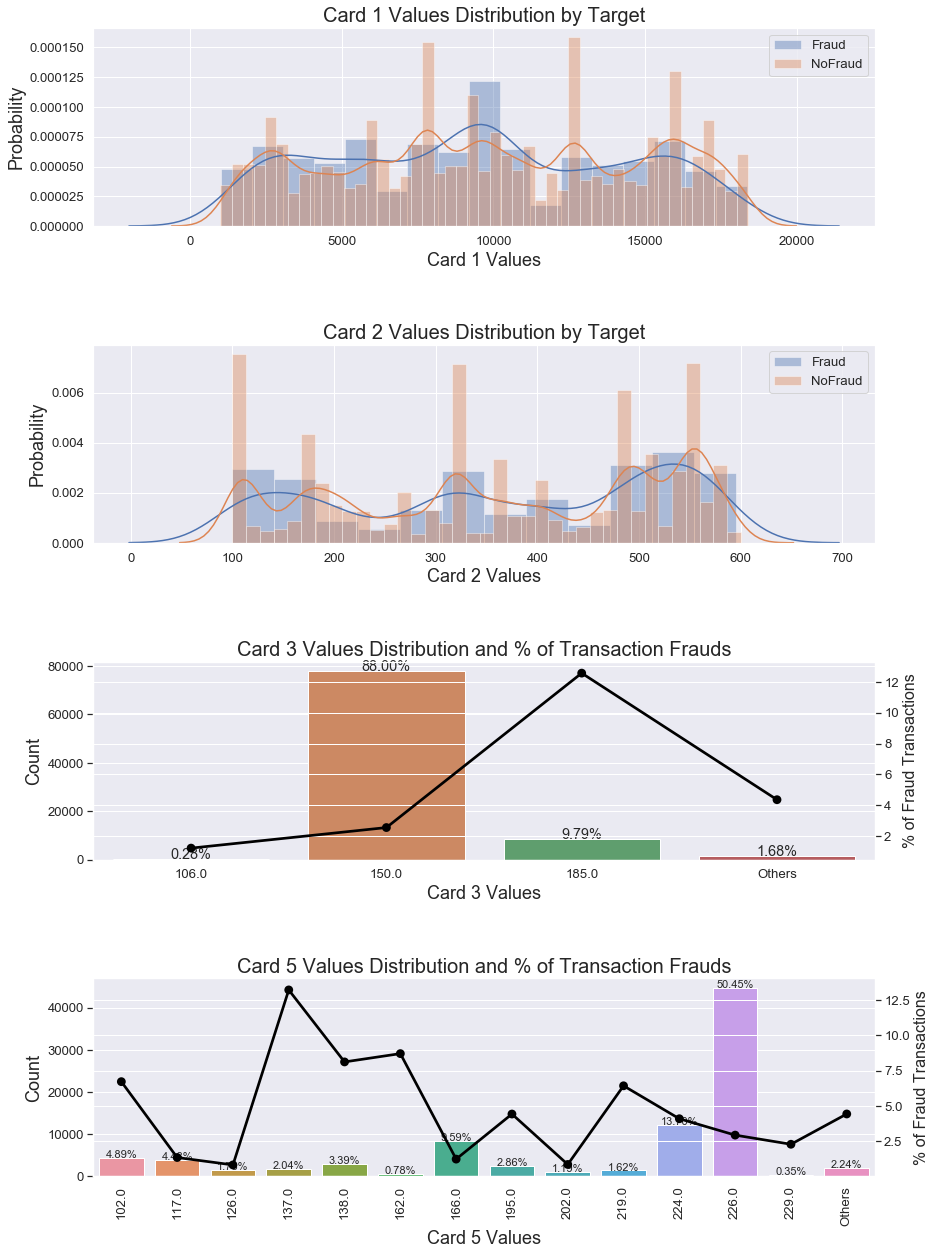

In [282]:
tmp = pd.crosstab(train['card3'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(train['card5'], train['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(train[train['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(train[train['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(train[train['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(train[train['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.countplot(x='card3', data=train, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
g3 = sns.countplot(x='card5', data=train, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

## Card 4-6 Variable (categorical)

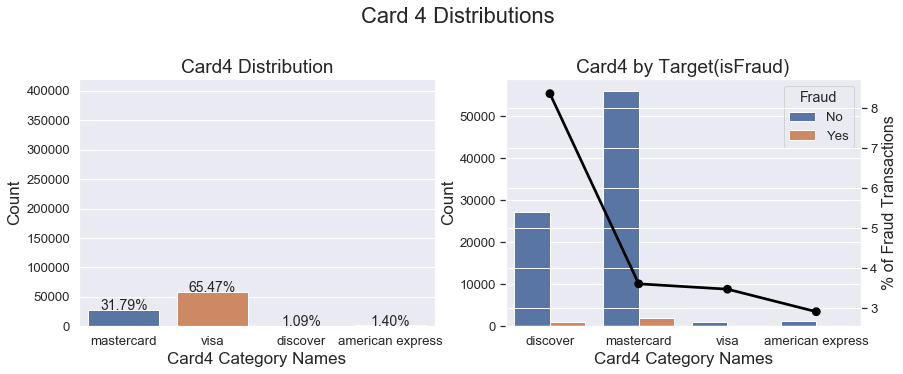

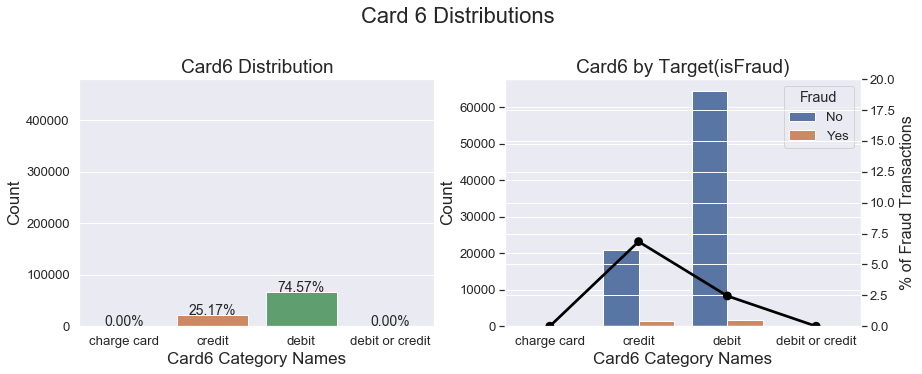

In [283]:
tmp = pd.crosstab(train['card4'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)





tmp = pd.crosstab(train['card6'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card6', data=train, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=19)
g.set_ylim(0,480000)
g.set_xlabel("Card6 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=train, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)


plt.show()

## Addr1 and Addr2 Variable (categorical)

* The host of the competition stated that these features are categorical even if they look numerical.

In [284]:
train["addr1"].value_counts()

299.0    6919
204.0    6294
325.0    6278
264.0    5999
330.0    4007
         ... 
232.0       1
218.0       1
303.0       1
162.0       1
102.0       1
Name: addr1, Length: 163, dtype: int64

In [285]:
train["addr2"].value_counts()

87.0     77811
60.0       472
96.0        96
32.0        15
65.0        14
31.0         7
19.0         7
26.0         4
16.0         4
68.0         3
69.0         3
71.0         3
48.0         2
59.0         2
27.0         2
74.0         2
92.0         1
29.0         1
47.0         1
100.0        1
38.0         1
61.0         1
57.0         1
10.0         1
88.0         1
102.0        1
78.0         1
17.0         1
52.0         1
40.0         1
101.0        1
21.0         1
39.0         1
Name: addr2, dtype: int64

* I will set all values in Addr1 that has less than 5000 entries to "Others" In Addr2 I will set as "Others" all values with less than 50 entries

In [286]:
train.loc[train.addr1.isin(train.addr1.value_counts()[train.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
train.loc[train.addr2.isin(train.addr2.value_counts()[train.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

In [287]:
test.loc[test.addr1.isin(test.addr1.value_counts()[test.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
test.loc[test.addr2.isin(test.addr2.value_counts()[test.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

In [288]:
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)

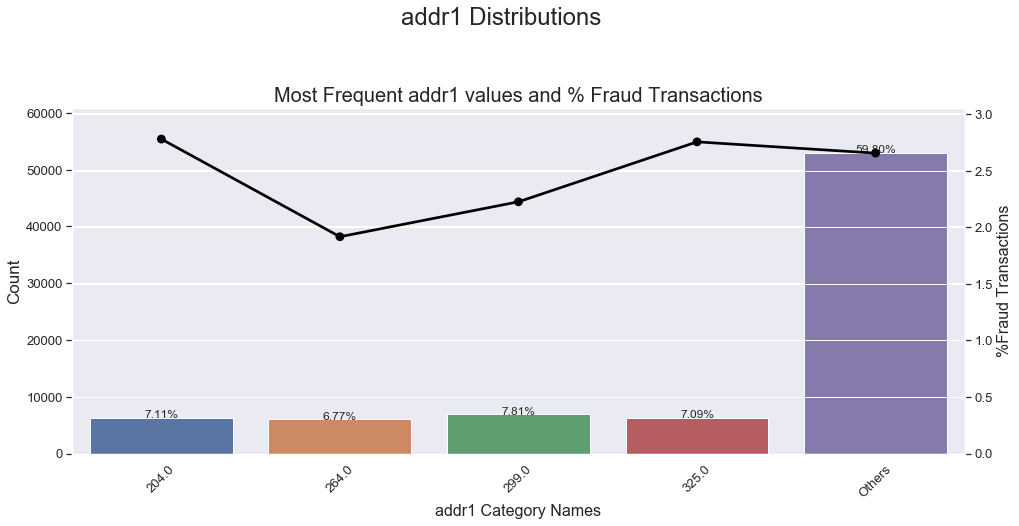

In [289]:
ploting_cnt_amt(train, 'addr1')

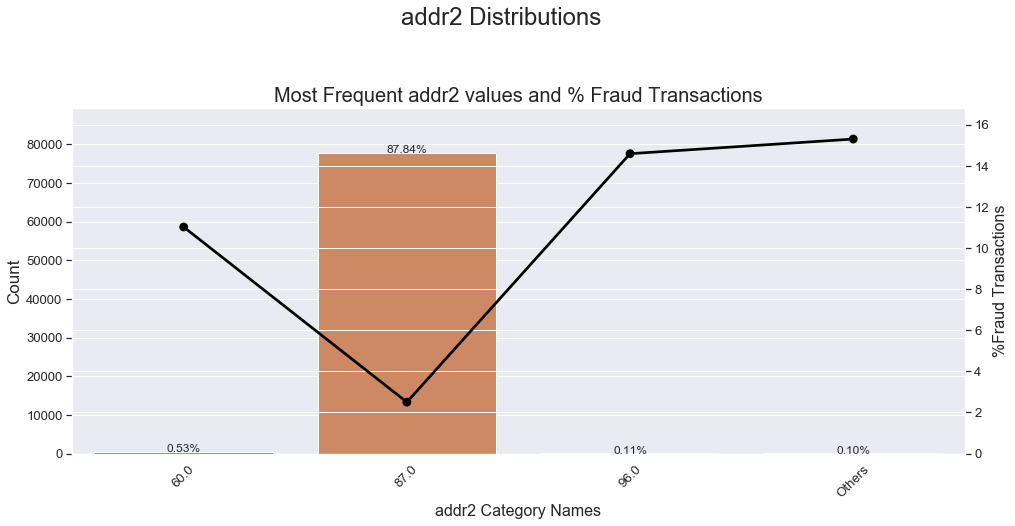

In [290]:
ploting_cnt_amt(train, 'addr2')

## Dist1 and Dist2 Variable

*  Possibly this could be the distance of the transaction vs. the card owner's home/work address. This is just a guess.

In [291]:
train["dist1"].describe()

count    35636.000000
mean       113.043299
std        359.113973
min          0.000000
25%          3.000000
50%          8.000000
75%         24.000000
max       7136.000000
Name: dist1, dtype: float64

In [292]:
train["dist2"].describe()

count    5648.000000
mean      228.095786
std       492.756849
min         0.000000
25%         7.000000
50%        44.000000
75%       219.000000
max      9103.000000
Name: dist2, dtype: float64

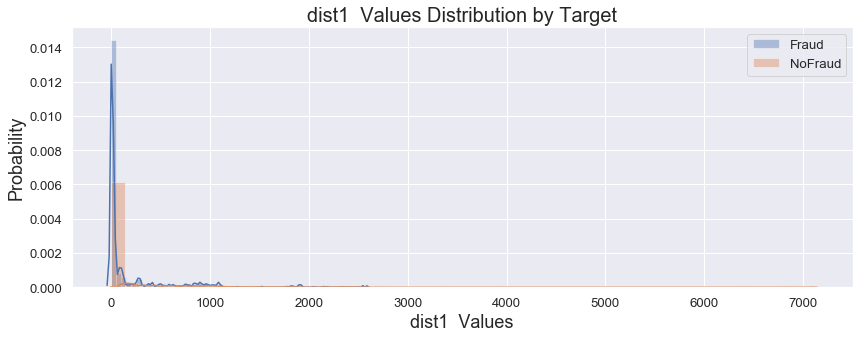

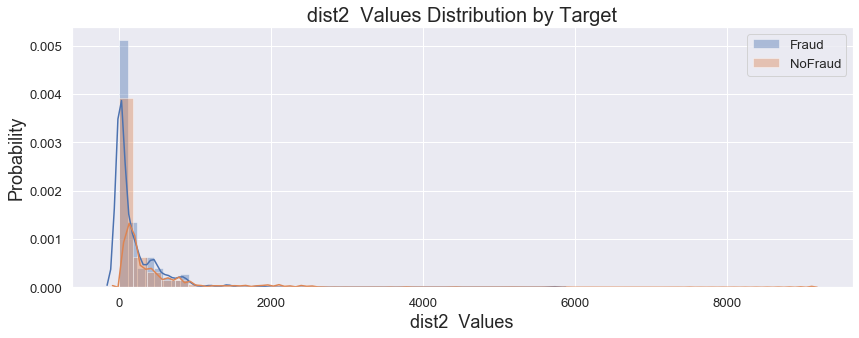

In [293]:
plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(train[train['isFraud'] == 1]['dist1'], label='Fraud')
g = sns.distplot(train[train['isFraud'] == 0]['dist1'], label='NoFraud')
g.legend()
g.set_title("dist1  Values Distribution by Target", fontsize=20)
g.set_xlabel("dist1  Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)


plt.show()


plt.figure(figsize=(14,22))


plt.subplot(412)
g1 = sns.distplot(train[train['isFraud'] == 1]['dist2'].dropna(), label='Fraud')
g1 = sns.distplot(train[train['isFraud'] == 0]['dist2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("dist2  Values Distribution by Target", fontsize=20)
g1.set_xlabel("dist2  Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)



plt.show()

## P_emaildomain and R_emaildomain Variable (categorical)

In [294]:
train['P_emaildomain'].isnull().sum()

14107

In [295]:
train["R_emaildomain"].isnull().sum()

67688

* I will group all e-mail domains by the respective enterprises.
* Also, I will set as "Others" all values with less than 500 entries for P_emaildomain
* Also, I will set as "Others" all values with less than 300 entries for R_emaildomain

In [296]:
#p_emaildomain_train

train["P_emaildomain"].unique()
train["P_emaildomain"].value_counts()

train.loc[train["P_emaildomain"].isin(['gmail.com', "gmail"]), "P_emaildomain"]= "Google"
train.loc[train["P_emaildomain"].isin(['yahoo.com', "yahoo.com.mx", 'yahoo.fr', 'yahoo.de','yahoo.es','yahoo.co.uk','yahoo.co.jp']), "P_emaildomain"]= "Yahoo Mail"
train.loc[train["P_emaildomain"].isin(['outlook.com', 'msn.com', 'live.com','live.com.mx', 'outlook.es','live.fr','hotmail.com','hotmail.es', 'hotmail.fr', 'hotmail.de', 'hotmail.co.uk' ]), "P_emaildomain"]= "Microsoft"
train.loc[train["P_emaildomain"].isin(['aol.com' ]), "P_emaildomain"]= "Aol"
train.loc[train["P_emaildomain"].isin(['anonymous.com' ]), "P_emaildomain"]= "Anonymous"
train.loc[train["P_emaildomain"].isin(train["P_emaildomain"].value_counts()[train["P_emaildomain"].value_counts()<=8000].index), "P_emaildomain"]= "Others"
#others belirlemek için girdiğimiz değer aldığımız sample a göre değişiyor
train["P_emaildomain"].fillna("NoInf", inplace=True)
train["P_emaildomain"].value_counts()
p_email_domain_ratio = (train["P_emaildomain"].value_counts() / train.shape[0] * 100).sort_values(ascending=False)



#p_emaildomain_test

test["P_emaildomain"].unique()
test["P_emaildomain"].value_counts()

test.loc[test["P_emaildomain"].isin(['gmail.com', "gmail"]), "P_emaildomain"]= "Google"
test.loc[test["P_emaildomain"].isin(['yahoo.com', "yahoo.com.mx", 'yahoo.fr', 'yahoo.de','yahoo.es','yahoo.co.uk','yahoo.co.jp']), "P_emaildomain"]= "Yahoo Mail"
test.loc[test["P_emaildomain"].isin(['outlook.com', 'msn.com', 'live.com','live.com.mx', 'outlook.es','live.fr','hotmail.com','hotmail.es', 'hotmail.fr', 'hotmail.de', 'hotmail.co.uk' ]), "p_emaildomain"]= "Microsoft"
test.loc[test["P_emaildomain"].isin(['aol.com' ]), "P_emaildomain"]= "Aol"
test.loc[test["P_emaildomain"].isin(['anonymous.com' ]), "P_emaildomain"]= "Anonymous"
test.loc[test["P_emaildomain"].isin(test["P_emaildomain"].value_counts()[test["P_emaildomain"].value_counts()<=21000].index), "P_emaildomain"]= "Others"
#others belirlemek için girdiğimiz değer aldığımız sample a göre değişiyor
test["P_emaildomain"].fillna("NoInf", inplace=True)
p_email_domain_ratio = (test["P_emaildomain"].value_counts() / test.shape[0] * 100).sort_values(ascending=False)


In [297]:
#r_emaildomain_train

train["R_emaildomain"].unique()
train["R_emaildomain"].value_counts()

train.loc[train["R_emaildomain"].isin(['gmail.com', "gmail"]), "R_emaildomain"]= "Google"
train.loc[train["R_emaildomain"].isin(['yahoo.com', "yahoo.com.mx", 'yahoo.fr', 'yahoo.de','yahoo.es','yahoo.co.uk','yahoo.co.jp']), "R_emaildomain"]= "Yahoo Mail"
train.loc[train["R_emaildomain"].isin(['outlook.com', 'msn.com', 'live.com','live.com.mx', 'outlook.es','live.fr','hotmail.com','hotmail.es', 'hotmail.fr', 'hotmail.de', 'hotmail.co.uk' ]), "R_emaildomain"]= "Microsoft"
train.loc[train["R_emaildomain"].isin(['aol.com']), "R_emaildomain"]= "Aol"
train.loc[train["R_emaildomain"].isin(['anonymous.com']), "R_emaildomain"]= "Anonymous"
train.loc[train["R_emaildomain"].isin(train["R_emaildomain"].value_counts()[train["R_emaildomain"].value_counts()<=2000].index), "R_emaildomain"]= "Others"
train["R_emaildomain"].fillna("NoInf", inplace=True)
r_email_domain_ratio = (train["R_emaildomain"].value_counts() / train.shape[0] * 100).sort_values(ascending=False)


#r_emaildomain_test

test["R_emaildomain"].unique()
test["R_emaildomain"].value_counts()

test.loc[test["R_emaildomain"].isin(['gmail.com', "gmail"]), "R_emaildomain"]= "Google"
test.loc[test["R_emaildomain"].isin(['yahoo.com', "yahoo.com.mx", 'yahoo.fr', 'yahoo.de','yahoo.es','yahoo.co.uk','yahoo.co.jp']), "R_emaildomain"]= "Yahoo Mail"
test.loc[test["R_emaildomain"].isin(['outlook.com', 'msn.com', 'live.com','live.com.mx', 'outlook.es','live.fr','hotmail.com','hotmail.es', 'hotmail.fr', 'hotmail.de', 'hotmail.co.uk' ]), "R_emaildomain"]= "Microsoft"
test.loc[test["R_emaildomain"].isin(['aol.com']), "R_emaildomain"]= "Aol"
test.loc[test["R_emaildomain"].isin(['anonymous.com']), "R_emaildomain"]= "Anonymous"
test.loc[test["R_emaildomain"].isin(test["R_emaildomain"].value_counts()[test["R_emaildomain"].value_counts()<=3000].index), "R_emaildomain"]= "Others"
test["R_emaildomain"].fillna("NoInf", inplace=True)
r_email_domain_ratio = (test["R_emaildomain"].value_counts() / test.shape[0] * 100).sort_values(ascending=False)


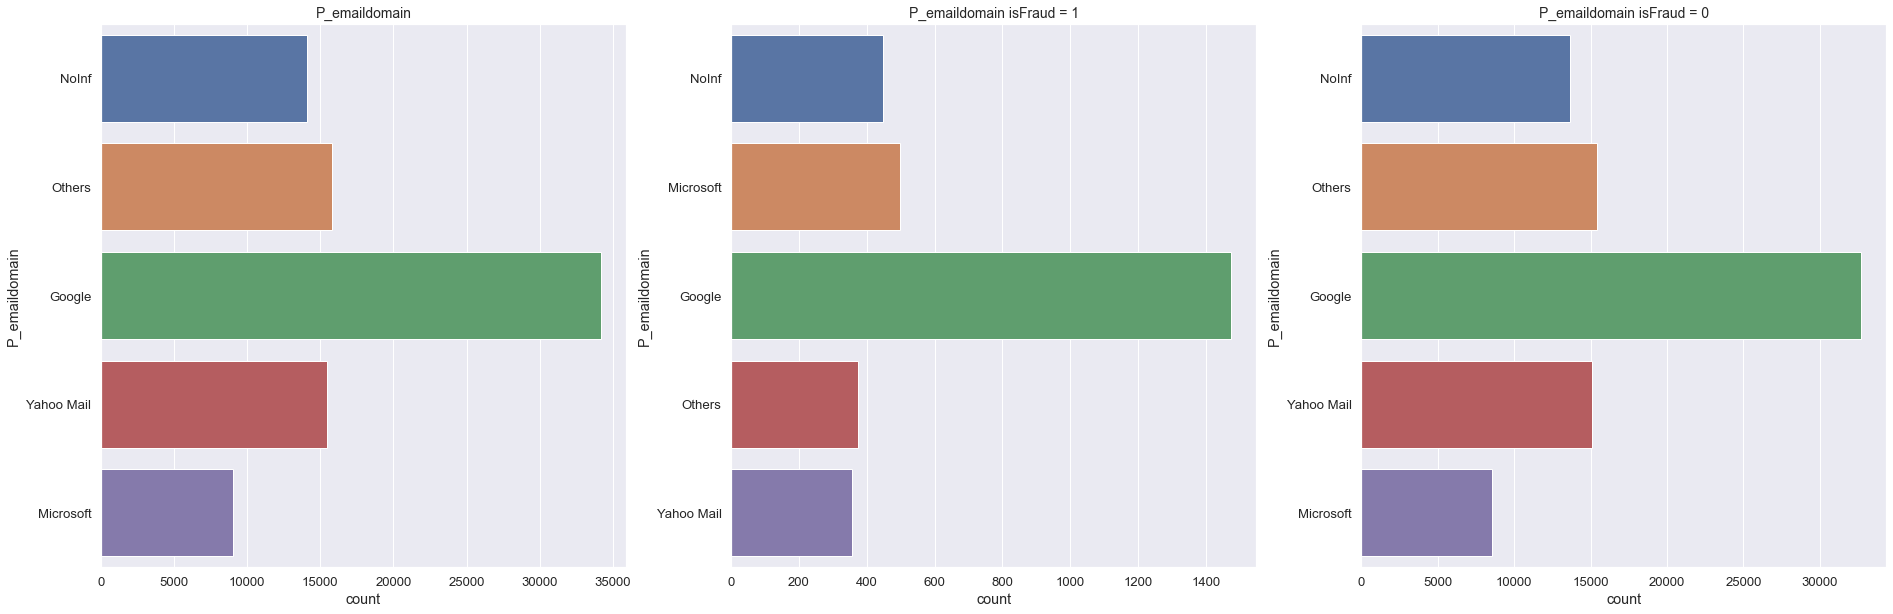

In [298]:
fig, ax = plt.subplots(1, 3, figsize=(32,10))

sns.countplot(y="P_emaildomain", ax=ax[0], data=train)
ax[0].set_title('P_emaildomain', fontsize=14)
sns.countplot(y="P_emaildomain", ax=ax[1], data=train.loc[train['isFraud'] == 1])
ax[1].set_title('P_emaildomain isFraud = 1', fontsize=14)
sns.countplot(y="P_emaildomain", ax=ax[2], data=train.loc[train['isFraud'] == 0])
ax[2].set_title('P_emaildomain isFraud = 0', fontsize=14)
plt.show()

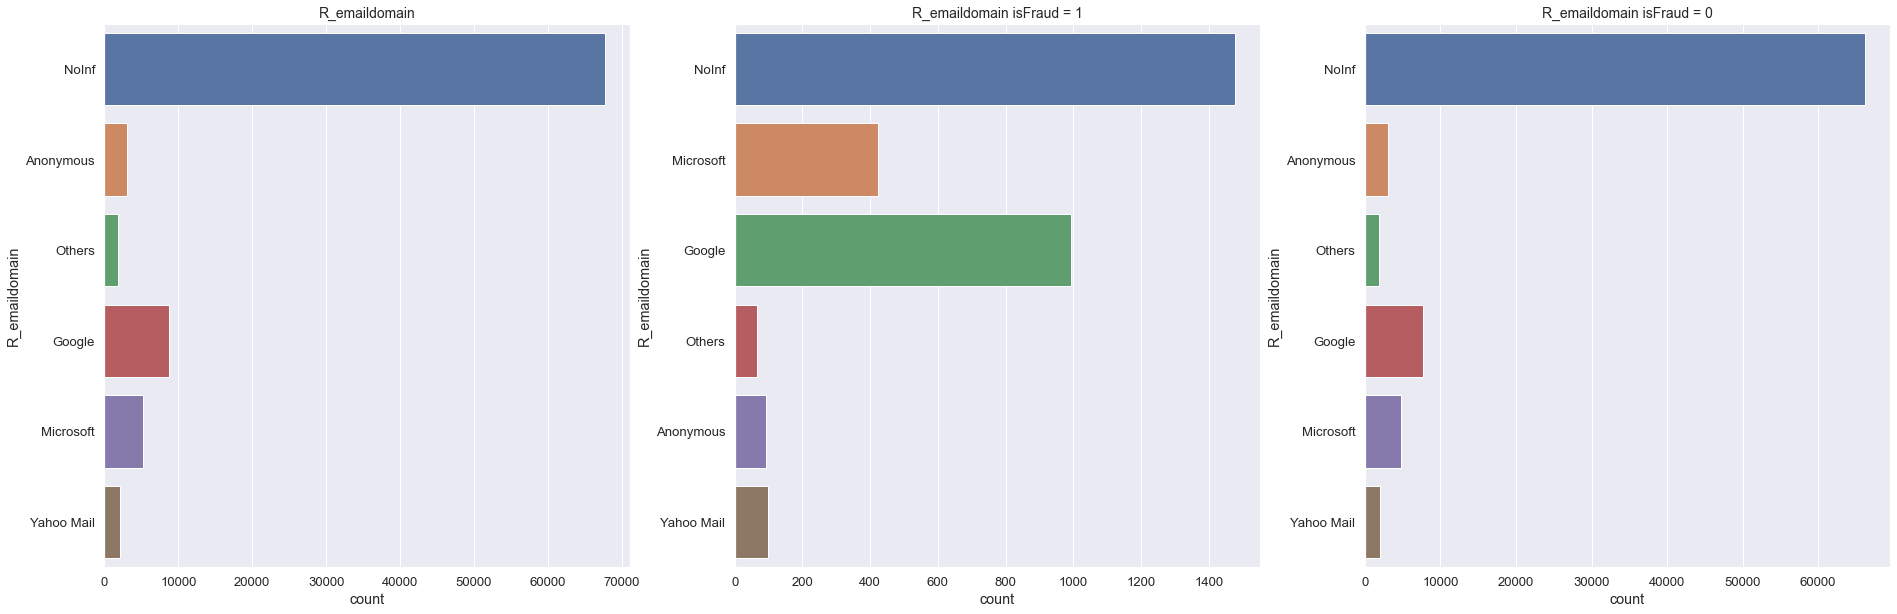

In [299]:
fig, ax = plt.subplots(1, 3, figsize=(32,10))

sns.countplot(y="R_emaildomain", ax=ax[0], data=train)
ax[0].set_title('R_emaildomain', fontsize=14)
sns.countplot(y="R_emaildomain", ax=ax[1], data=train.loc[train['isFraud'] == 1])
ax[1].set_title('R_emaildomain isFraud = 1', fontsize=14)
sns.countplot(y="R_emaildomain", ax=ax[2], data=train.loc[train['isFraud'] == 0])
ax[2].set_title('R_emaildomain isFraud = 0', fontsize=14)
plt.show()

* It seems that criminals prefer gmail

## C 1-14 Variable (categorical)

*C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is 0masked.

*All of the C features are continuous.

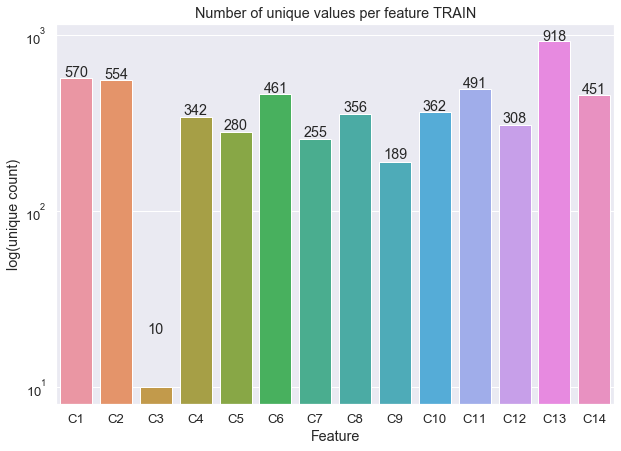

In [300]:
plt.figure(figsize=(10, 7))
c_features = list(train.columns[17:31])
uniques = [len(train[col].unique()) for col in c_features]
sns.set(font_scale=1.2)
ax = sns.barplot(c_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

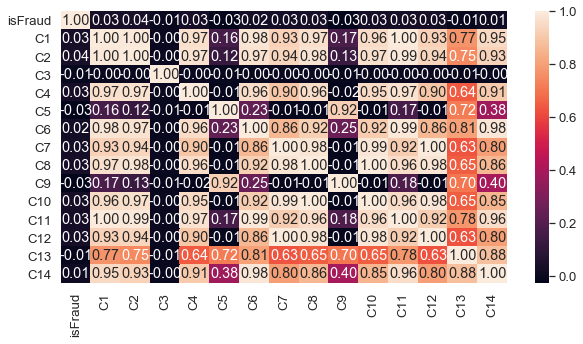

In [301]:
ccols = [f'C{i}' for i in range(1,15)]
plt.figure(figsize=(10,5))

corr = train[['isFraud'] + ccols].corr()
sns.heatmap(corr, annot=True, fmt='.2f')


## D1-15 Variable 

*The D Columns are "time deltas" from some point in the past.


In [302]:
d_cols = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14']
train[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14
128037,207.0,87.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,207.0,87.0,NaN,NaN,NaN
491755,0.0,NaN,0.0,594.0,0.0,NaN,NaN,NaN,NaN,112.0,529.0,NaN,NaN,NaN
470924,100.0,100.0,8.0,101.0,8.0,NaN,NaN,NaN,NaN,43.0,616.0,NaN,NaN,NaN
491263,133.0,133.0,NaN,NaN,NaN,NaN,NaN,1004.458313,0.458333,133.0,NaN,NaN,NaN,NaN
371403,28.0,28.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,345.0,345.0,NaN,NaN,NaN


In [303]:
train[d_cols].describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14
count,88379.000000,46394.000000,48923.000000,63254.000000,41960.000000,11251.000000,5981.000000,11323.000000,11323.000000,77157.000000,46594.000000,9938.000000,9493.000000,9522.000000
mean,93.112380,168.012459,27.909654,138.481203,42.397116,70.409564,42.604080,145.758438,0.561582,122.885973,144.494570,54.170759,17.572316,58.095253
std,156.666631,176.987562,61.184762,190.445978,89.301950,144.295338,100.096915,232.539864,0.316451,182.087745,184.904014,124.092869,68.129056,137.006839
min,0.000000,0.000000,0.000000,-53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.958333,0.208333,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,95.000000,8.000000,24.000000,9.000000,0.000000,0.000000,37.625000,0.666666,15.000000,42.000000,0.000000,0.000000,0.000000
75%,119.000000,271.000000,27.000000,250.750000,32.000000,40.000000,18.000000,189.312500,0.833333,194.000000,267.000000,12.000000,0.000000,2.000000
max,640.000000,640.000000,729.000000,860.000000,734.000000,849.000000,759.000000,1517.833374,0.958333,859.000000,664.000000,648.000000,797.000000,860.000000


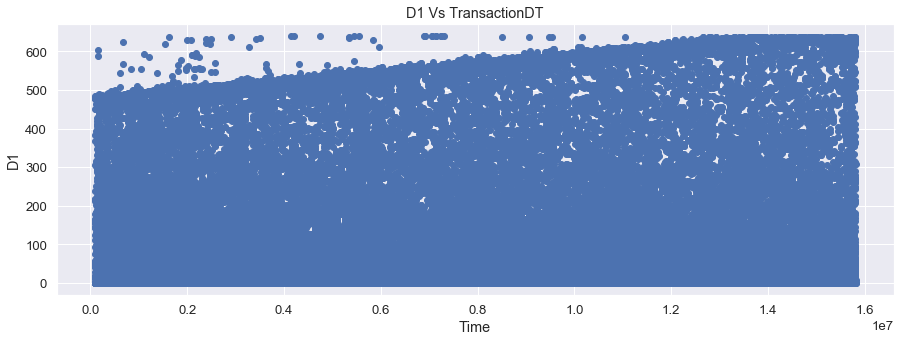

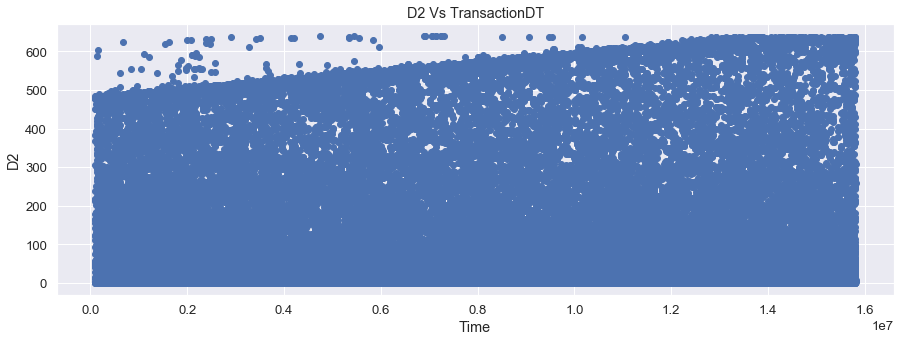

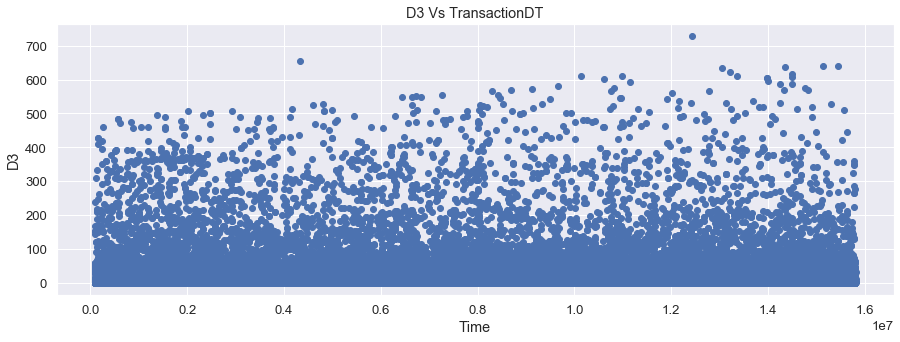

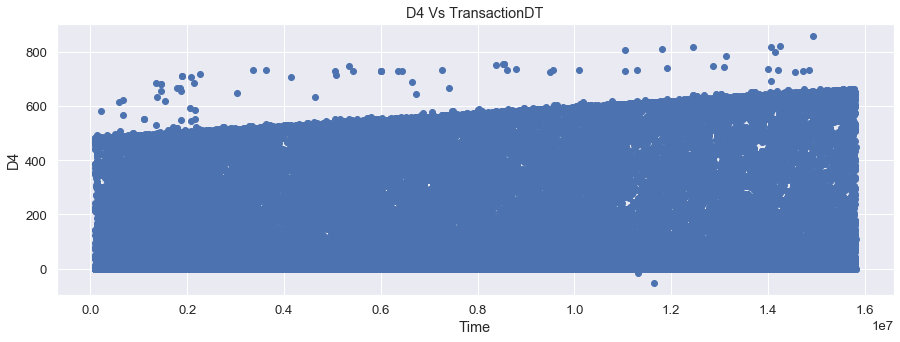

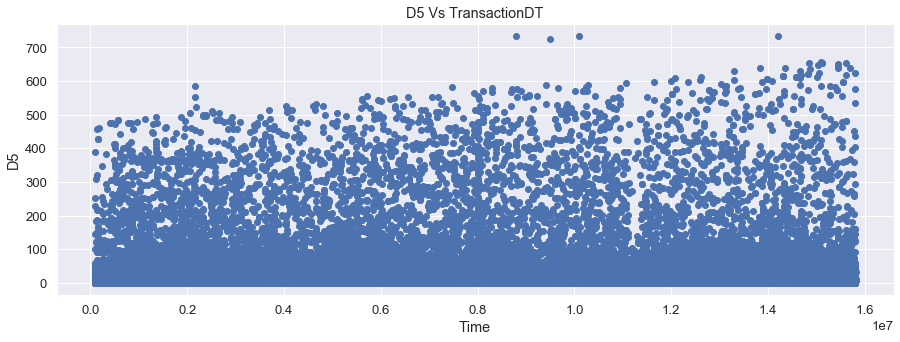

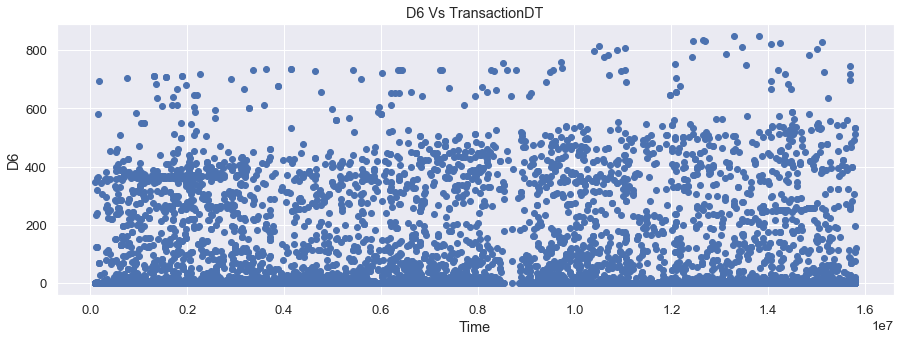

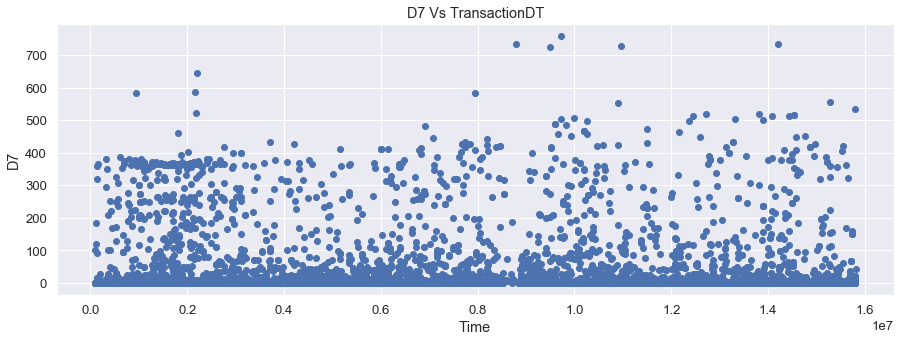

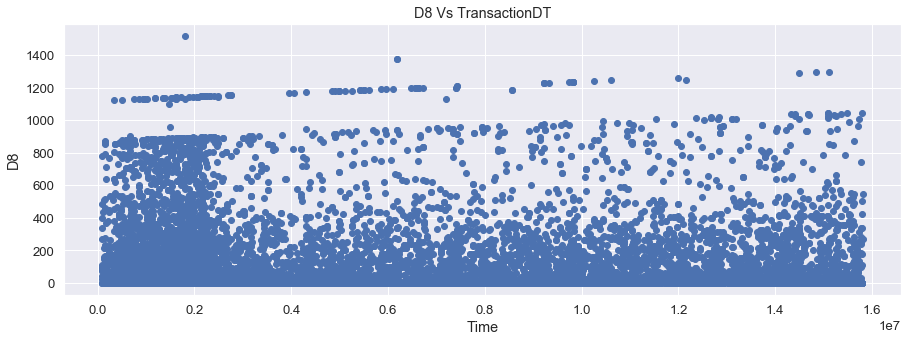

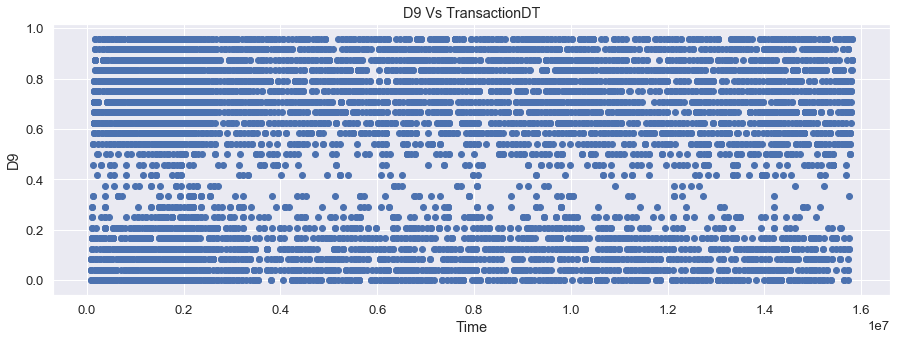

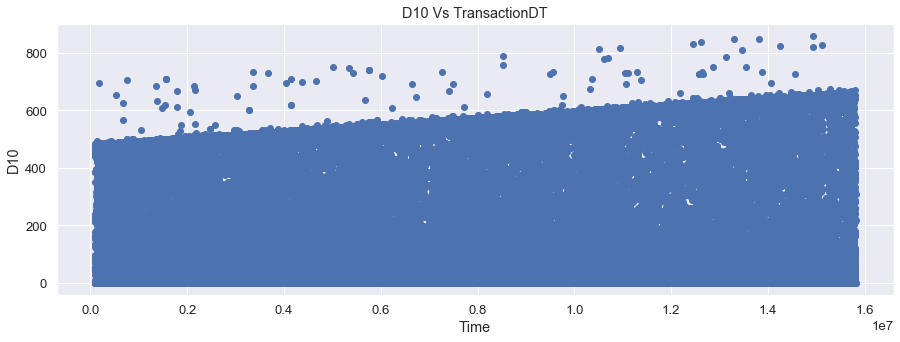

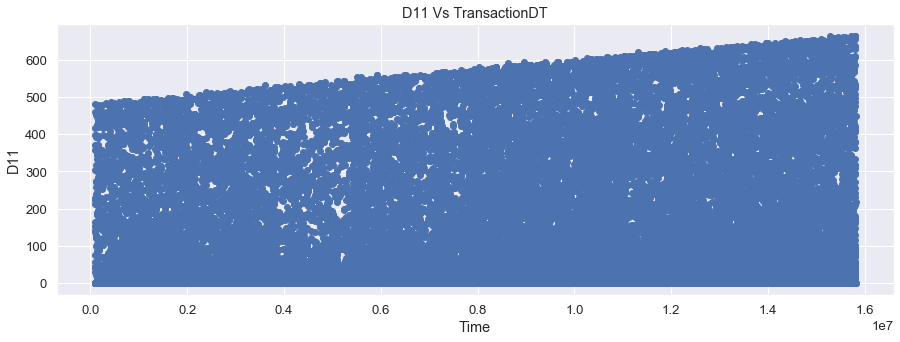

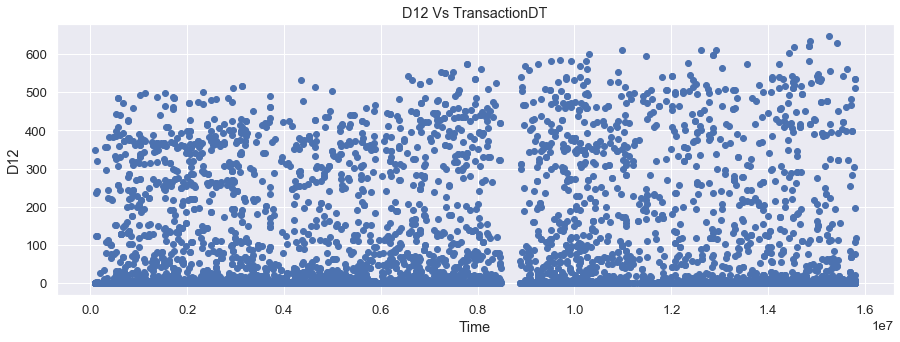

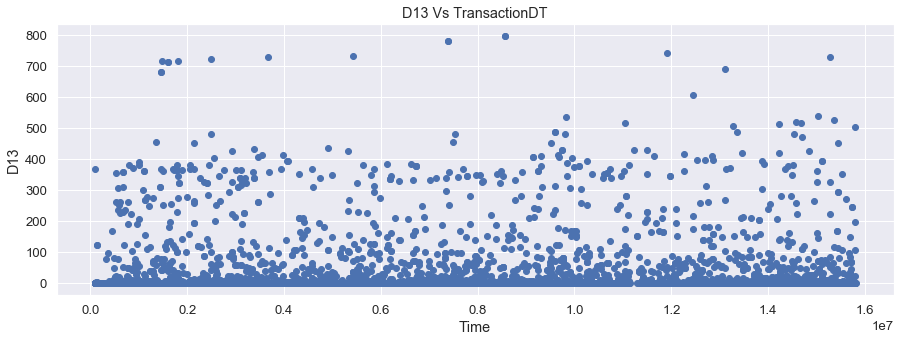

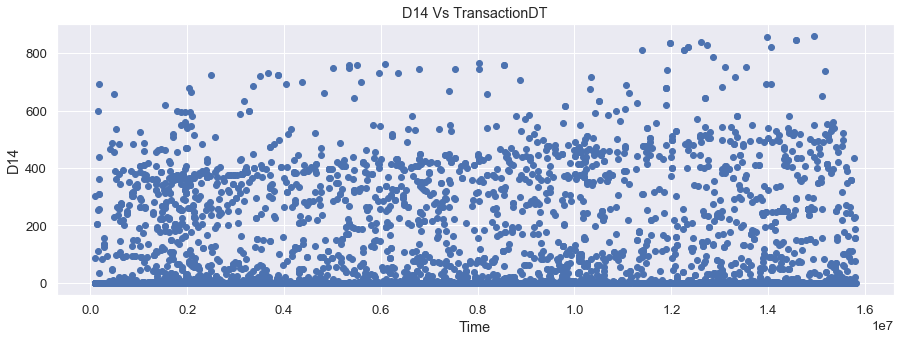

In [304]:
for col in d_cols:
    plt.figure(figsize=(15,5))
    plt.scatter(train['TransactionDT'] ,train[col])
    plt.title(col + ' Vs TransactionDT')
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.show()

## M1-M9 Variable

* M1-M9 : match, such as names on card and address, etc.
* All of the M features are categorical.
* Values are T F or NaN except M4.
* M4 feature appears to be different from others.

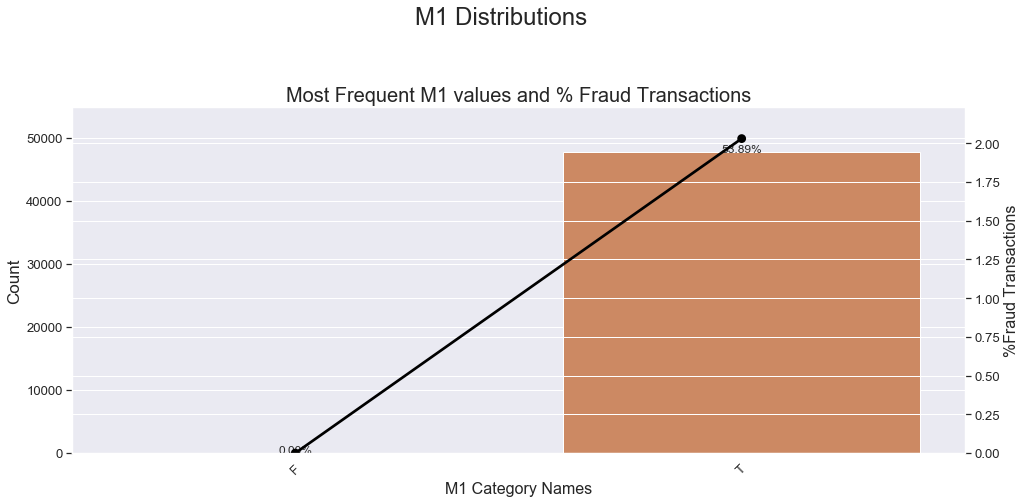

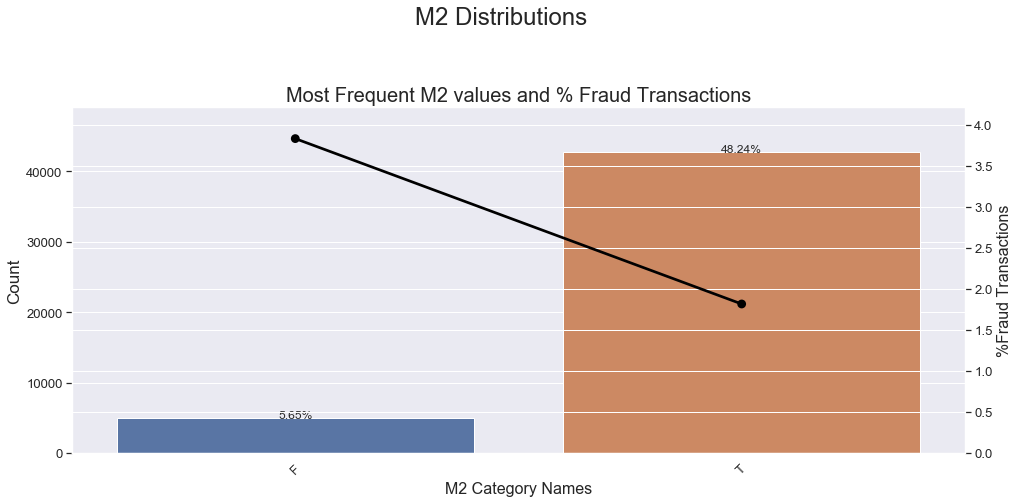

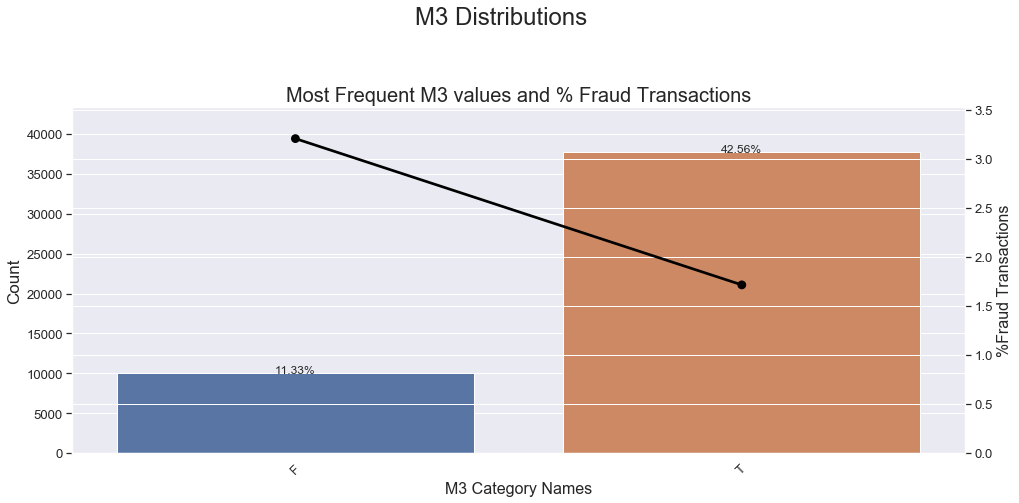

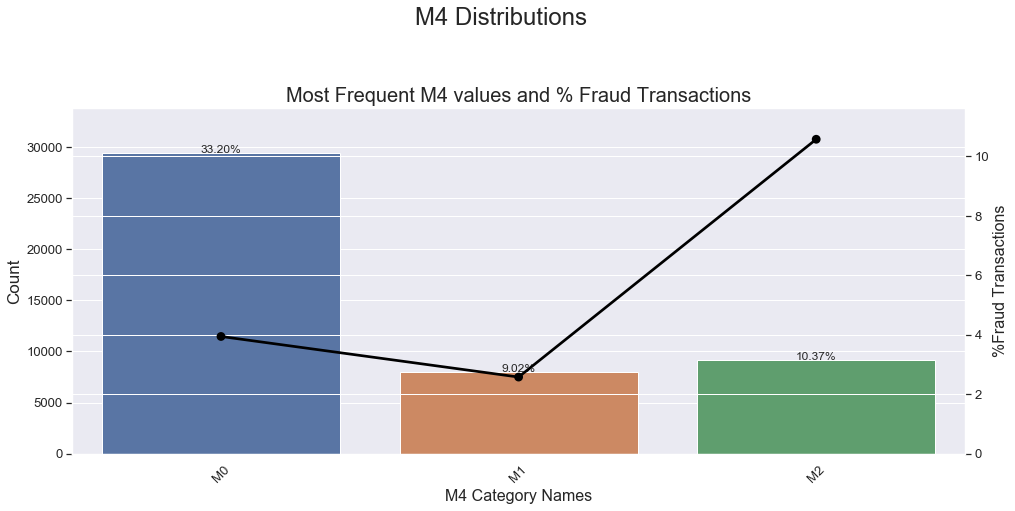

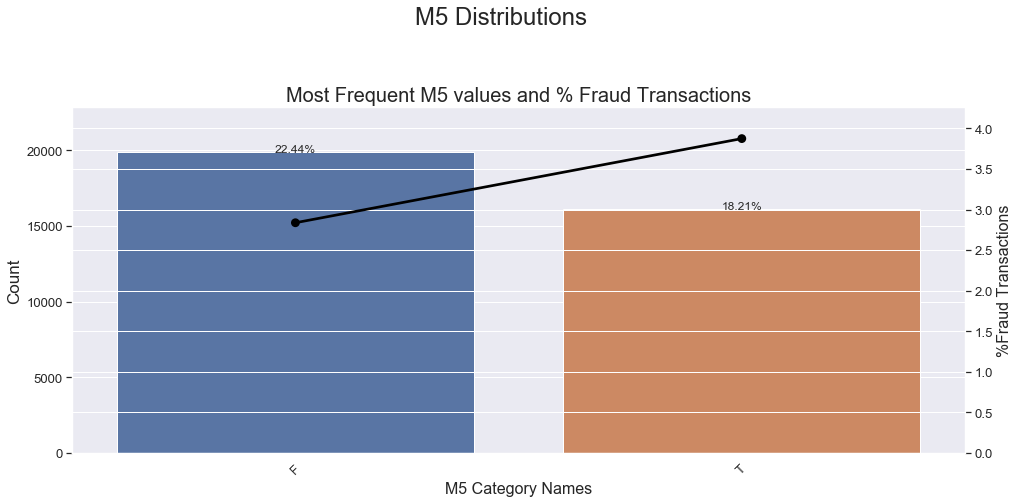

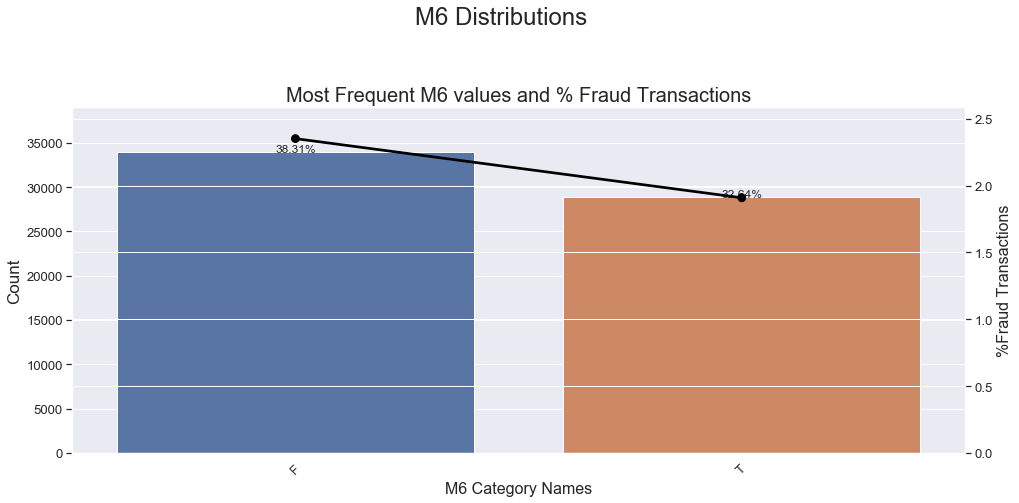

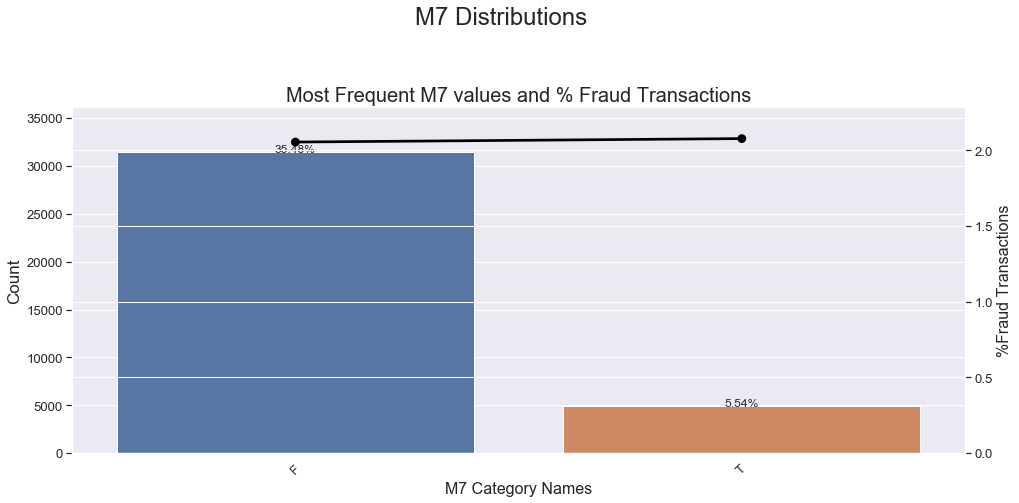

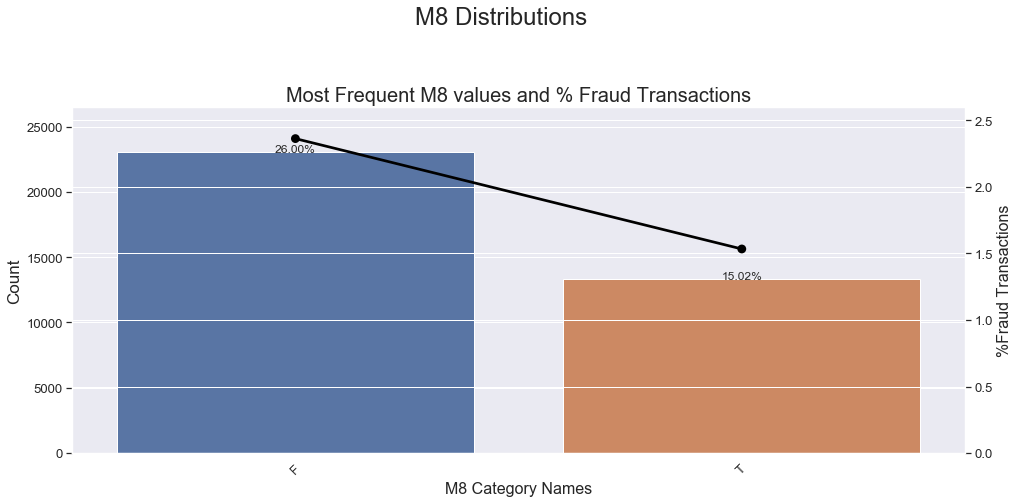

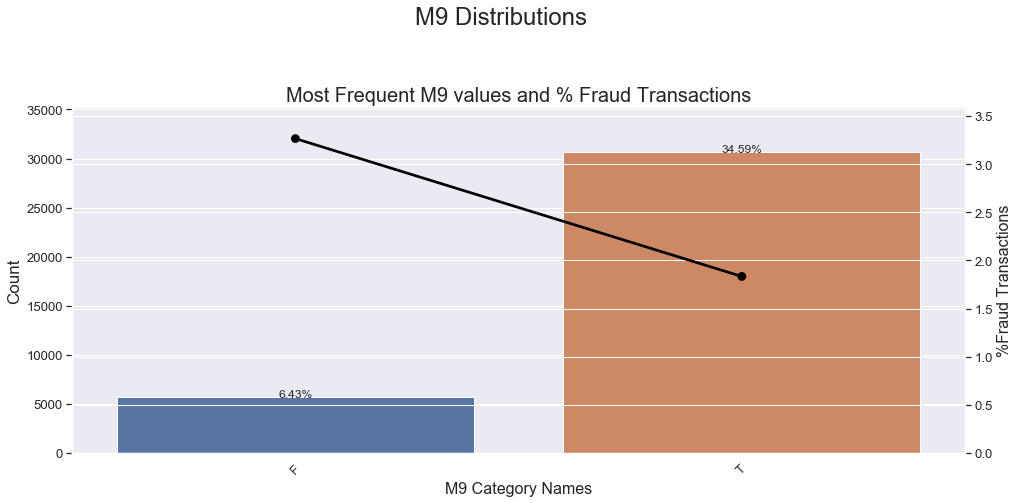

In [305]:
m_cols = [c for c in train if c[0] == 'M']
for col in m_cols:
    ploting_cnt_amt(train, col, lim=2500)

## DeviceType Variable

* Most of the fraudulent transactions were done by the mobile device.

In [306]:
train['DeviceType'].value_counts()

desktop    12926
mobile      8499
Name: DeviceType, dtype: int64

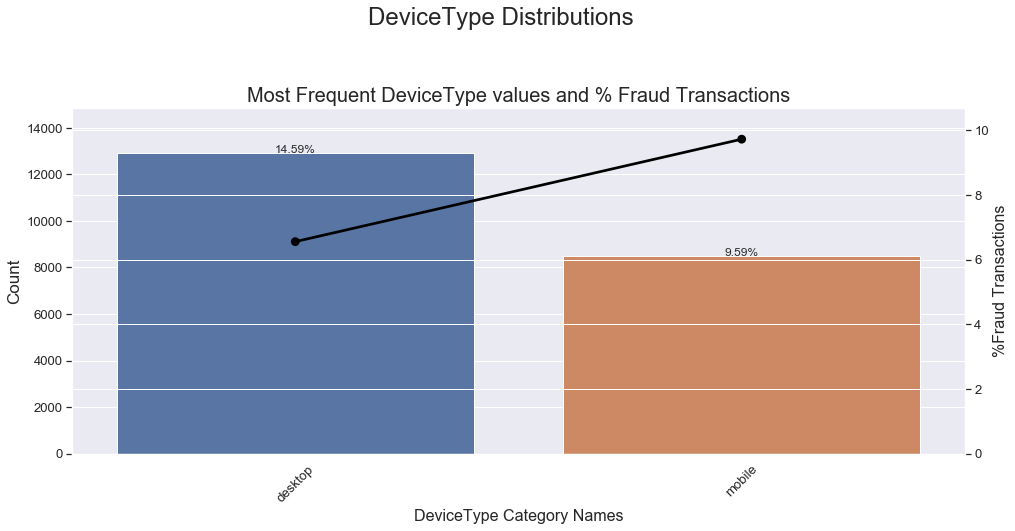

In [307]:
ploting_cnt_amt(train, 'DeviceType')

## DeviceInfo Variable

In [308]:
train['DeviceInfo'].value_counts()

Windows                 7294
iOS Device              3019
MacOS                   1871
Trident/7.0             1139
rv:11.0                  280
                        ... 
A1601 Build/LMY47I         1
LG-H811 Build/MRA58K       1
rv:42.0                    1
SM-G935U                   1
verykools5034              1
Name: DeviceInfo, Length: 937, dtype: int64

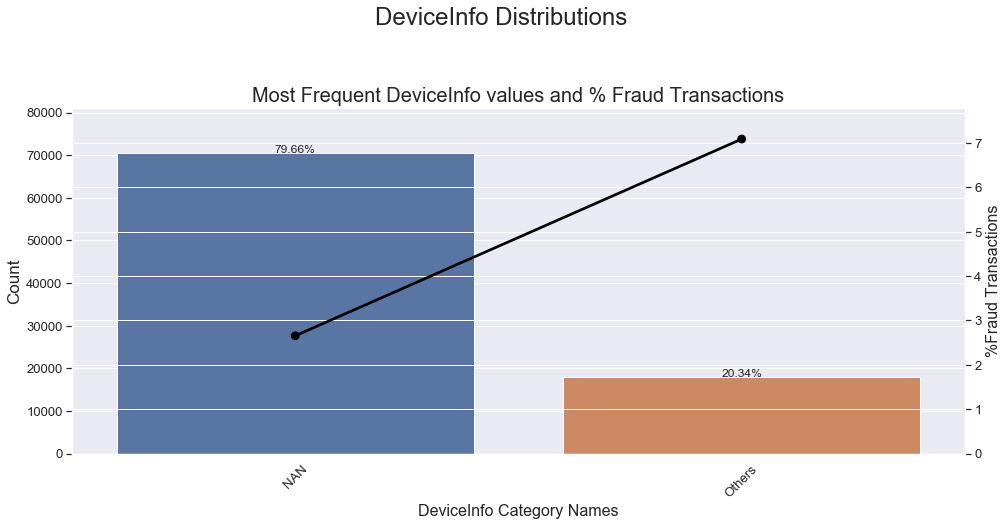

In [248]:
ploting_cnt_amt(df, 'DeviceInfo')

In [310]:
train["DeviceInfo"].unique()
train.loc[train['DeviceInfo'].str.contains('SM', na=False), 'DeviceInfo'] = 'Samsung'
train.loc[train['DeviceInfo'].str.contains('Moto', na=False), 'DeviceInfo'] = 'Motorola'
train.loc[train['DeviceInfo'].str.contains('moto', na=False), 'DeviceInfo'] = 'Motorola'
train.loc[train['DeviceInfo'].str.contains('HUAWEI', na=False), 'DeviceInfo'] = 'Huawei'
train.loc[train['DeviceInfo'].str.contains('LG', na=False), 'DeviceInfo'] = 'LG'
train.loc[train['DeviceInfo'].str.contains('GT-', na=False), 'DeviceInfo'] = 'Samsung'
train.loc[train['DeviceInfo'].str.contains('Trident', na=False), 'DeviceInfo'] = 'Trident'
train.loc[train['DeviceInfo'].str.contains('BLADE', na=False), 'DeviceInfo'] = 'ZTE'
train.loc[train['DeviceInfo'].isin(train['DeviceInfo'].value_counts()[train['DeviceInfo'].value_counts() < 7570].index), 'DeviceInfo'] = "Others"
train["DeviceInfo"].fillna("NAN", inplace=True)

#deviceinfo test

test["DeviceInfo"].unique()
test.loc[test['DeviceInfo'].str.contains('SM', na=False), 'DeviceInfo'] = 'Samsung'
test.loc[test['DeviceInfo'].str.contains('Moto', na=False), 'DeviceInfo'] = 'Motorola'
test.loc[test['DeviceInfo'].str.contains('moto', na=False), 'DeviceInfo'] = 'Motorola'
test.loc[test['DeviceInfo'].str.contains('HUAWEI', na=False), 'DeviceInfo'] = 'Huawei'
test.loc[test['DeviceInfo'].str.contains('LG', na=False), 'DeviceInfo'] = 'LG'
test.loc[test['DeviceInfo'].str.contains('GT-', na=False), 'DeviceInfo'] = 'Samsung'
test.loc[test['DeviceInfo'].str.contains('Trident', na=False), 'DeviceInfo'] = 'Trident'
test.loc[test['DeviceInfo'].str.contains('BLADE', na=False), 'DeviceInfo'] = 'ZTE'
test.loc[test['DeviceInfo'].isin(test['DeviceInfo'].value_counts()[test['DeviceInfo'].value_counts() < 6000].index), 'DeviceInfo'] = "Others"
test["DeviceInfo"].fillna("NAN", inplace=True)

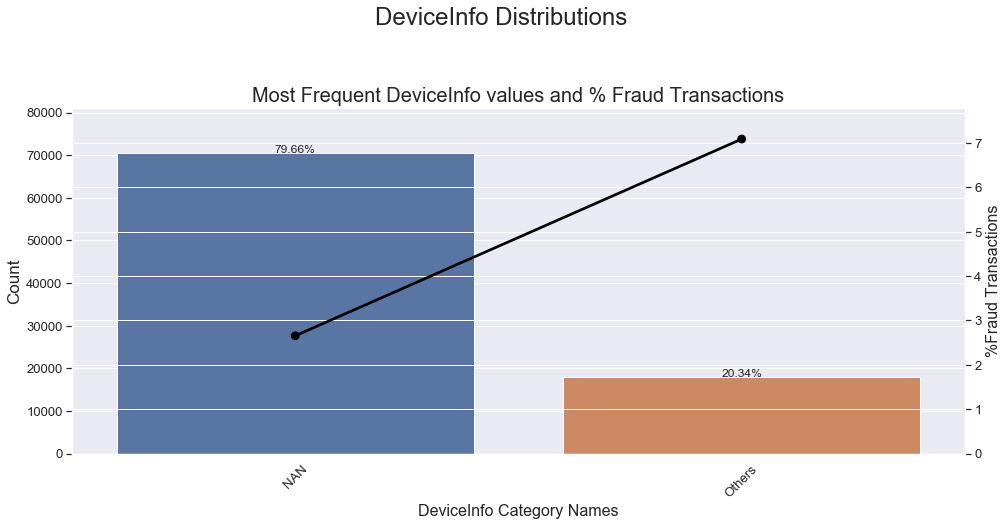

In [311]:
ploting_cnt_amt(train, 'DeviceInfo')

## id1-id38 variable

* id1-id11 are numeric features
* id12-id38 are categorical features.

In [312]:
id_cols = [c for c in train if c[:2] == 'id']

id_num_cols=id_cols[:11]
id_cat_cols=id_cols[11:]

In [313]:
train[id_num_cols].describe()


,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
count,21962.000000,21440.000000,10050.000000,10050.000000,20879.000000,20879.000000,813.000000,813.000000,11323.000000,11323.000000,21459.000000
mean,-10.250114,175169.891138,0.058109,-0.053831,1.587576,-6.553714,14.099631,-37.790898,0.097324,-0.303983,99.758023
std,14.345521,159941.184445,0.563604,0.648481,5.157374,15.852578,10.787407,25.123793,0.929162,2.716702,1.092197
min,-100.000000,1.000000,-12.000000,-13.000000,-33.000000,-100.000000,-21.000000,-100.000000,-24.000000,-100.000000,90.000000
25%,-10.000000,68416.250000,0.000000,0.000000,0.000000,-6.000000,6.000000,-48.000000,0.000000,0.000000,100.000000
50%,-5.000000,126789.000000,0.000000,0.000000,0.000000,0.000000,14.000000,-33.000000,0.000000,0.000000,100.000000
75%,-5.000000,228264.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,0.000000,100.000000
max,0.000000,993114.000000,6.000000,0.000000,47.000000,0.000000,48.000000,0.000000,25.000000,0.000000,100.000000


## V1 - V339 variable


In [ ]:
v_cols = [c for c in train_transaction if c[0] == 'V']
train_transaction[v_cols].head()

In [ ]:
train_transaction[v_cols].describe()


In [ ]:
train_transaction['v_mean'] = train_transaction[v_cols].mean(axis=1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train_transaction.loc[train_transaction['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train_transaction.loc[train_transaction['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          color=color_pal[5],
          ax=ax2)
plt.show()